# Data exploration

This notebook goes through:
- Initial exploratory analysis of the data
- Feature extraction using FFT
- An initial attempt at classification 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
# Fast Fourier Transform
from scipy.fft import fft, ifft
from scipy.signal import correlate, find_peaks, spectrogram
# Classifier
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("deep")

In [2]:
from gaitkeeper.idnet import load_idnet_dataset
from gaitkeeper.preprocess import get_fft, get_top_signal_peaks

## Load reference dataset

First, load the dataset. Note this involves cleaning (aligning the sensor frequencies and interpolating missing data (skipped measurements).

In [3]:
idnet, uid_to_label = load_idnet_dataset(chunksize=256, window_step=256, normalize="within")

Loading IDNet dataset...


In [4]:
print(f"Number of users in dataset: {len(uid_to_label)}")

Number of users in dataset: 29


In [5]:
# Split separate walk sessions
train = []
test = []
for chunk in idnet:
    if chunk.iloc[0]["walk_id"] == 1:  # last walk
        train.append(chunk)
    else:  # all others as training
        test.append(chunk)

In [6]:
len(train), len(test)

(1985, 6055)

## Fourier analysis

In [7]:
f_s = 60  # Sampling rate of 60 Hz

In [8]:
def plot_fft(f_s, *signals):
    f, ax = plt.subplots(figsize=(15, 5))
    f_vals = []
    fft_vals = []
    for i, signal in enumerate(signals):
        f_val, fft_val = get_fft(signal, f_s)
        f_vals.append(f_val)
        fft_vals.append(fft_val)
        ax.plot(f_val, fft_val, "--" if i%2==1 else "-", label=i)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    sns.despine()
    return list(zip(f_vals, fft_vals))

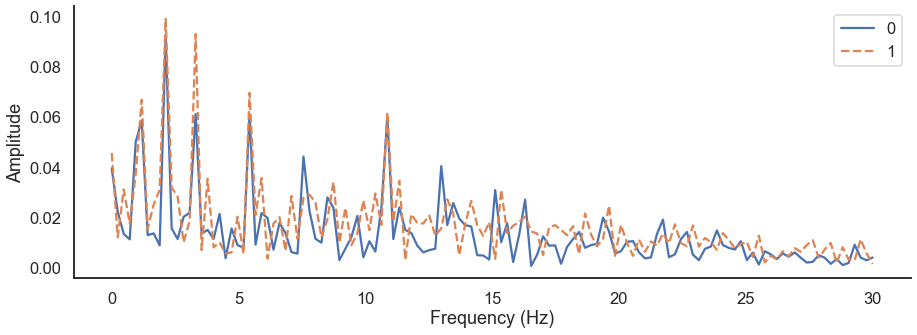

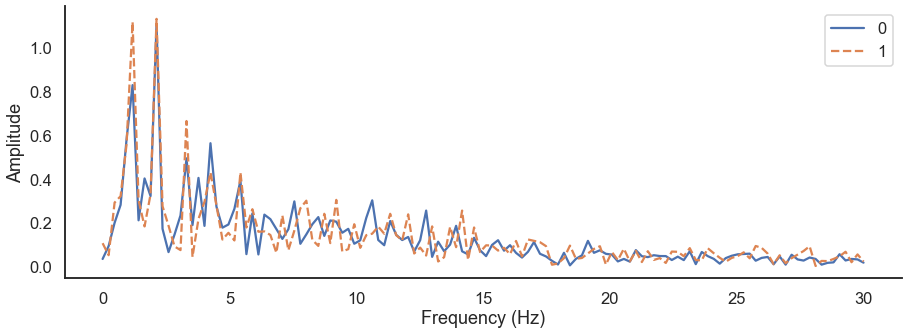

In [9]:
# Plot adjacent subsequences within the same walk
(f1, fft1), (f2, fft2) = plot_fft(f_s, train[0]["linearaccelerometer_mag"].values, train[1]["linearaccelerometer_mag"].values)
(f1, fft1), (f2, fft2) = plot_fft(f_s, train[0]["gyroscope_mag"].values, train[1]["gyroscope_mag"].values)

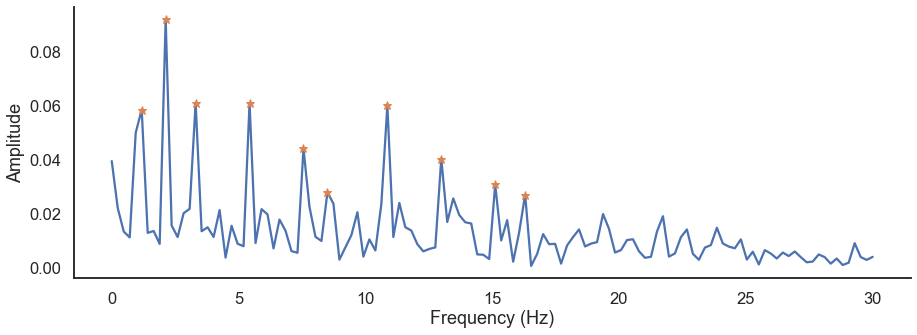

In [10]:
f, ax = plt.subplots(figsize=(15, 5))
f_val, fft_val = get_fft(train[0]["linearaccelerometer_mag"].values, f_s)
ax.plot(f_val, fft_val)
ax.plot(*get_top_signal_peaks(f_val, fft_val, 10), "*")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
sns.despine()

## Convert data to feature vectors

- Iterate over users
- Chunk recording information and convert to feature (linearaccelerometer + gyroscope data)
- Label feature with user and walk number

In [11]:
def create_features_from_fft_peaks(chunks, n_peaks=10):
    """Create DataFrame of feature vectors using Fourier peaks."""
    features = []
    for chunk in chunks:
        user = chunk["user_id"].iloc[0]
        walk = chunk["walk_id"].iloc[0]
        norm_acc = chunk["linearaccelerometer_mag"].values
        norm_gyro = chunk["gyroscope_mag"].values
        f_acc, fft_acc = get_fft(norm_acc, f_s)
        peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, n_peaks)
        f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
        peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, n_peaks)
        # concatenate the features
        feature_vector = np.concatenate([[user, walk], peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
        features.append(feature_vector)

    df_features = pd.DataFrame(features, 
        columns=["user_id", "walk_id", 
               *[f"acc_f{i}" for i in range(n_peaks)], *[f"acc_fft{i}" for i in range(n_peaks)],
               *[f"gyro_f{i}" for i in range(n_peaks)], *[f"gyro_fft{i}" for i in range(n_peaks)]
    ])
    df_features["user_id"] = df_features["user_id"].astype(int)
    df_features["walk_id"] = df_features["walk_id"].astype(int)
    return df_features

In [12]:
df_features_train = create_features_from_fft_peaks(train, n_peaks=10)
df_features_test = create_features_from_fft_peaks(test, n_peaks=10)

## Fit data to initial classification model

- Make sure when splitting into training/test data that we don't mix walks in either set (leakage)
- This is just to test if the individuals can indeed be resolved

In [13]:
df_features_train.head()

,user_id,walk_id,acc_f0,acc_f1,acc_f2,acc_f3,acc_f4,acc_f5,acc_f6,acc_f7,...,gyro_fft0,gyro_fft1,gyro_fft2,gyro_fft3,gyro_fft4,gyro_fft5,gyro_fft6,gyro_fft7,gyro_fft8,gyro_fft9
0,0,1,2.125984,3.307087,5.433071,10.866142,1.181102,7.559055,12.992126,15.118110,...,1.103494,0.827053,0.562273,0.493266,0.404183,0.401754,0.392380,0.302058,0.297120,0.255270
1,0,1,2.125984,3.307087,5.433071,1.181102,10.866142,5.905512,3.779528,11.338583,...,1.128895,1.115131,0.663351,0.428738,0.428615,0.304039,0.300383,0.261520,0.255301,0.240637
2,0,1,2.125984,3.307087,5.433071,1.181102,10.629921,8.740157,13.700787,12.755906,...,0.949146,0.729373,0.546921,0.360630,0.336358,0.255729,0.245470,0.223421,0.182579,0.178311
3,0,1,2.125984,1.181102,3.307087,5.433071,10.866142,8.740157,15.354331,16.535433,...,1.000227,0.854592,0.649992,0.421718,0.419255,0.312805,0.311305,0.304508,0.299311,0.285438
4,0,1,2.125984,3.307087,1.181102,5.433071,13.464567,8.267717,0.472441,18.897638,...,1.161746,0.984703,0.875341,0.548380,0.542087,0.514401,0.448415,0.410770,0.388618,0.376766


In [14]:
# Select peaks as features (starting from 2nd index)
train = df_features_train
y_train, X_train = train.iloc[:, 0], train.iloc[:, 2:]
test = df_features_test
y_test, X_test = test.iloc[:, 0], test.iloc[:, 2:]

In [15]:
trees = RandomForestClassifier(class_weight="balanced")

In [16]:
trees.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
train["predicted_user"] = trees.predict(X_train)
test["predicted_user"] = trees.predict(X_test)

Text(0.5, 1.0, 'Training set confusion matrix')

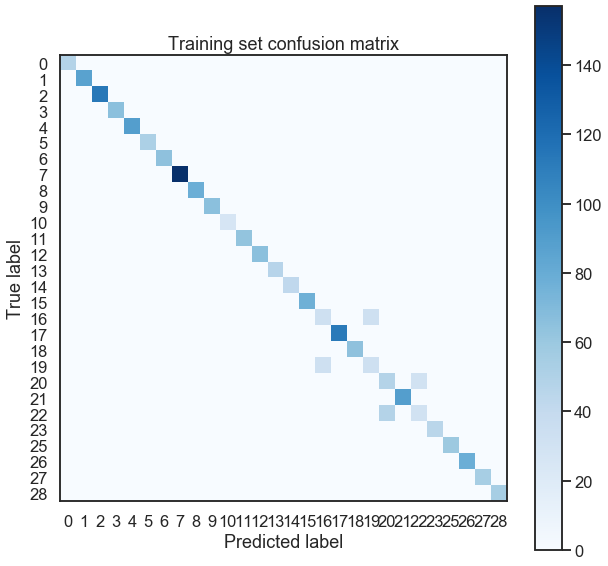

In [18]:
f, ax = plt.subplots(figsize=(10,10))
metrics.plot_confusion_matrix(trees, X_train, y_train, ax=ax, cmap="Blues", values_format="g", include_values=False)
ax.set_title("Training set confusion matrix")

Text(0.5, 1.0, 'Test set confusion matrix')

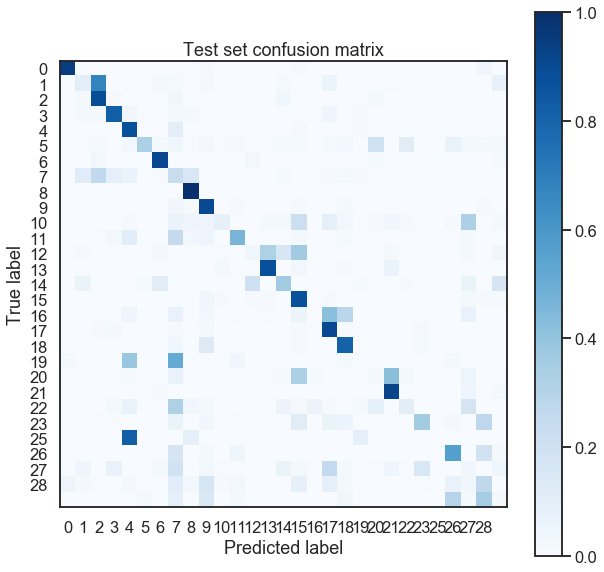

In [19]:
f, ax = plt.subplots(figsize=(10,10))
metrics.plot_confusion_matrix(trees, X_test, y_test, ax=ax, cmap="Blues", normalize="true", include_values=False)
ax.set_title("Test set confusion matrix")

This is obviously over-fitting to the training set, but the signal is promising.

In [20]:
print(f"Balanced Accuracy: {metrics.balanced_accuracy_score(y_test, test['predicted_user'])*100:.2F}%")

Balanced Accuracy: 47.21%


What if we aggregate the final prediction per-walk by taking a majority vote across all samples?

In [21]:
cm = metrics.confusion_matrix(y_test, test["predicted_user"])
majority_predicted_is_true = [row.argmax() == i for i, row in enumerate(cm)]
print(f"Per-User Accuracy (majority vote): {sum(majority_predicted_is_true) / len(cm) * 100:.2F}%")

Per-User Accuracy (majority vote): 62.07%
